<a href="https://colab.research.google.com/github/PadmarajBhat/Machine-Learning/blob/master/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of 3 Brain Tumors (Meningioma, Glioma and Pituitary) in T1-weighted contrast enhanced images

### - Revisitng the Udacity Capstone Project in pursuit of better accuracy



# Import Packages
* read the input MRI images (.mat) files through ***h5py***
* ***pandas*** for data analysis and preprocessing
* ***tensorflow*** for modelling and predicting

In [0]:
import os
import zipfile
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

# Load Data
* Mount Google Drive
* Unzip it in colab disk
* load mat attributes to list of tuples
* create a panda dataframe for analysis

##### Issues Faced:
* loading to panda with image took half(6GB) of RAM
* loading tumor along with mri image as in mat file crashed the colab
  * Solution: let us load image but save only 5 point summary for both mri image and tumor

* How do we scale/normalize the data?
  * would tumor region have 0 in it ?
    * only way to know is through the value present in the binary indicator == 1

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
!ls /content/drive/'My Drive'/1512427

brainTumorDataPublic_1533-2298.zip  brainTumorDataPublic_767-1532.zip
brainTumorDataPublic_1-766.zip	    cvind.mat
brainTumorDataPublic_2299-3064.zip  README.txt


In [14]:
!ls /content/drive/'My Drive'/1512427/brainTumorDataPublic_1-766.zip

'/content/drive/My Drive/1512427/brainTumorDataPublic_1-766.zip'


In [15]:

from sklearn.preprocessing import MinMaxScaler
data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
scaler = MinMaxScaler()
scaler.fit(data)
scaler.transform(data)

array([[0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [1.  , 1.  ]])

In [0]:
def return_imageInfo_from_mat_file(file_name):
    f = h5py.File(file_name,'r')

    mri_image = np.array(f['cjdata']['image'],dtype=np.int)
    #scaler = MinMaxScaler(feature_range=(1,2))
    #mri_image = scaler.fit(mri_image)
    mri_image = mri_image/mri_image.max()

    mri_quartiles = np.percentile(mri_image, [25, 50, 75])

    tumor_image = np.array(f['cjdata']['tumorMask'], dtype=np.int)
    tumor_array =[]
    for i in range(0,512):
      for j in range(0,512):
        if tumor_image[i][j]:
          tumor_array.append(mri_image[i][j])

    tumor_image = np.array(tumor_array, dtype=np.float)
    tumor_quartiles = np.percentile(tumor_image, [25, 50, 75])

    return np.array(f['cjdata']['PID'],dtype=np.int)[0][0] \
            ,mri_image.min() \
            ,mri_image.max() \
            ,mri_quartiles[1] \
            ,mri_quartiles[0] \
            ,mri_quartiles[2] \
            ,tumor_image.min() \
            ,tumor_image.max() \
            ,tumor_quartiles[1] \
            ,tumor_quartiles[0] \
            ,tumor_quartiles[2] \
            ,np.array(f['cjdata']['label'], dtype=np.int)[0][0] 

In [0]:
def loadDf():
  patients_details = []
  for root, dirs, files in os.walk("/content/drive/My Drive/1512427/", topdown = False):
    for f in files:
      if ".zip" in f:
          file = zipfile.ZipFile(root+f, "r")
          for name in file.namelist():
            file.extract(name,".")
            patients_details.append(return_imageInfo_from_mat_file(name))
          #break
      #break
  mri_col_names = ["mri_min","mri_max","mri_median","mri_1q", "mri_3q"]
  tumor_col_names = ["t_min","t_max","t_median","t_1q","t_3q"]
  col_names = ["pid"] + mri_col_names + tumor_col_names+ ["label"]
  return pd.DataFrame(patients_details,columns=col_names)


In [22]:
tumor_names = ["","meningioma","glioma","pituitary"]
df = loadDf()
df.sample(20)

,pid,mri_min,mri_max,mri_median,mri_1q,mri_3q,t_min,t_max,t_median,t_1q,t_3q,label
3023,49,0.0,1.0,0.114608,0.000000,0.308025,0.0,0.670351,0.0,0.0,0.0,3
1936,77,0.0,1.0,0.027027,0.007601,0.245355,0.0,0.648438,0.0,0.0,0.0,2
3060,49,0.0,1.0,0.016887,0.000000,0.216593,0.0,0.523495,0.0,0.0,0.0,3
2858,56,0.0,1.0,0.033898,0.013460,0.308574,0.0,0.614158,0.0,0.0,0.0,2
1590,77,0.0,1.0,0.011412,0.000000,0.184023,0.0,0.635521,0.0,0.0,0.0,2
2757,49,0.0,1.0,0.228856,0.047761,0.298507,0.0,0.634826,0.0,0.0,0.0,3
955,49,0.0,1.0,0.230641,0.032473,0.299334,0.0,0.556619,0.0,0.0,0.0,3
2143,77,0.0,1.0,0.155670,0.018557,0.310309,0.0,0.674227,0.0,0.0,0.0,2
1602,77,0.0,1.0,0.009511,0.000000,0.199126,0.0,0.843630,0.0,0.0,0.0,2
1941,77,0.0,1.0,0.013024,0.006418,0.241978,0.0,0.371272,0.0,0.0,0.0,2


# Analysis


In [23]:
df.pid.unique()

array([49, 57, 53, 77, 56])

There are only 5 patients info present !!!!

In [32]:
df.groupby("pid").agg("count").reset_index()[['pid','mri_min']]

,pid,mri_min
0,49,1427
1,53,2
2,56,13
3,57,401
4,77,1221


In [31]:
df.groupby(["pid","label"]).agg("count").reset_index()[['pid','label','mri_min']]

,pid,label,mri_min
0,49,1,584
1,49,2,126
2,49,3,717
3,53,1,1
4,53,3,1
5,56,1,1
6,56,2,12
7,57,1,122
8,57,2,67
9,57,3,212


In [33]:
df.groupby("label").agg("count").reset_index()[['label','pidb']]

,label,pid
0,1,708
1,2,1426
2,3,930


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd705cba0b8>]],
      dtype=object)

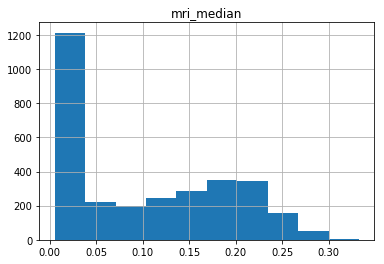

In [34]:
df.hist("mri_median")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7031dde10>]],
      dtype=object)

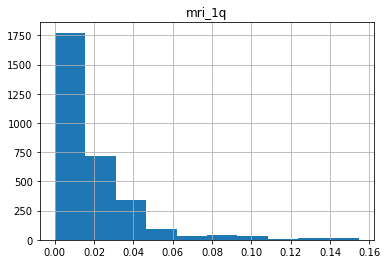

In [35]:
df.hist('mri_1q')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7031444a8>]],
      dtype=object)

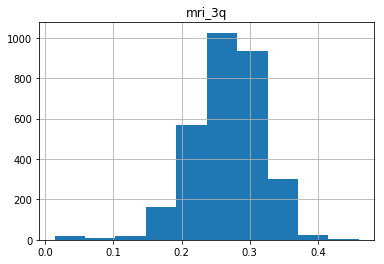

In [36]:
df.hist('mri_3q')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd703170e80>]],
      dtype=object)

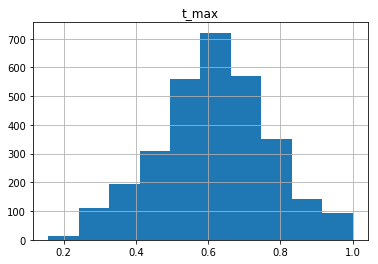

In [37]:
df.hist('t_max')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd703010710>]],
      dtype=object)

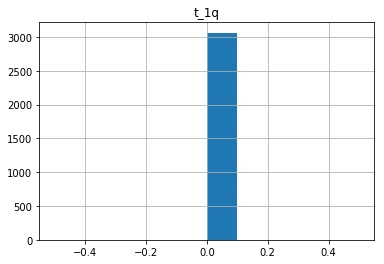

In [40]:
df.hist('t_1q')

# Preprocessing


Preprocessing ideas:

1.  Dataset has tumor region indicator which would allow us to get the average brightness of the area.

2. It is said that brightest region is skull and skull is not important for the tumor detection. It is only brain position determines the tumor class. If we remove skull remaining image is brain ?

3. if we start with a window of image which would maximize the presence of tumor and expand to include some brain region around the tumor then i guess it is the best data for training(and predicting). Because tumor position in brain is THE factor that decides the tumor class.